# 数据挖掘-互评作业二：网页浏览行为关联规则挖掘

## 3120220942 李响

In [1]:
# 检查并安装必要的包
!pip show mlxtend
# %time !pip install mlxtend

Name: mlxtend
Version: 0.22.0
Summary: Machine Learning Library Extensions
Home-page: https://github.com/rasbt/mlxtend
Author: Sebastian Raschka
Author-email: mail@sebastianraschka.com
License: BSD 3-Clause
Location: c:\users\26947\anaconda3\envs\pytorch\lib\site-packages
Requires: joblib, matplotlib, numpy, pandas, scikit-learn, scipy, setuptools
Required-by: 


In [2]:
# 导入必要的包
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import warnings
warnings.filterwarnings('ignore')

## 1. 数据预处理

**清洗数据，处理缺失值，提取用户浏览记录。**

In [3]:
#读入文件
data=[]
with open('anonymous-msweb.data', 'r') as f_input:
    for line in f_input:
        data.append(list(line.strip().split(',')))
data

[['I', '4', '"www.microsoft.com"', '"created by getlog.pl"'],
 ['T', '1', '"VRoot"', '0', '0', '"VRoot"'],
 ['N', '0', '"0"'],
 ['N', '1', '"1"'],
 ['T', '2', '"Hide1"', '0', '0', '"Hide"'],
 ['N', '0', '"0"'],
 ['N', '1', '"1"'],
 ['A', '1287', '1', '"International AutoRoute"', '"/autoroute"'],
 ['A', '1288', '1', '"library"', '"/library"'],
 ['A', '1289', '1', '"Master Chef Product Information"', '"/masterchef"'],
 ['A', '1297', '1', '"Central America"', '"/centroam"'],
 ['A', '1215', '1', '"For Developers Only Info"', '"/developer"'],
 ['A', '1279', '1', '"Multimedia Golf"', '"/msgolf"'],
 ['A', '1239', '1', '"Microsoft Consulting"', '"/msconsult"'],
 ['A', '1282', '1', '"home"', '"/home"'],
 ['A', '1251', '1', '"Reference Support"', '"/referencesupport"'],
 ['A', '1121', '1', '"Microsoft Magazine"', '"/magazine"'],
 ['A', '1083', '1', '"MS Access Support"', '"/msaccesssupport"'],
 ['A', '1145', '1', '"Visual Fox Pro Support"', '"/vfoxprosupport"'],
 ['A', '1276', '1', '"Visual Test

In [4]:
#提取网页id与title，URL之间的关系
vroot = pd.DataFrame(columns=['index','id','title','URL'])

for i in range(len(data)):
    if(data[i][0]=='A'):
        df2 = pd.DataFrame({'index': data[i][1], 'id': data[i][1],'title':data[i][3],'URL':data[i][4]},index=[0])
        vroot = pd.concat([vroot,df2])
vroot.sort_values(by=['id'], ascending=[True], inplace=True, ignore_index=True)
vroot = vroot.set_index(['index'])
vroot

,id,title,URL
index,,,
1000,1000,"""regwiz""","""/regwiz"""
1001,1001,"""Support Desktop""","""/support"""
1002,1002,"""End User Produced View""","""/athome"""
1003,1003,"""Knowledge Base""","""/kb"""
1004,1004,"""Microsoft.com Search""","""/search"""
...,...,...,...
1292,1292,"""MS North Africa""","""/northafrica"""
1293,1293,"""Encarta""","""/encarta"""
1294,1294,"""Bookshelf""","""/bookshelf"""


In [5]:
#建立数据集，其中每一条记录对应一个访问者id，包含该访问者访问的所有网站id
id_set= []
vroot_set = []
vr = []

dataset = {}
for i in range(len(data)):
    if(data[i][0]=='C'):
        vroot_set.append(vr)
        id_set.append(data[i][2])
        vr = []
    if(data[i][0]=='V'):
        vr.append(data[i][1])
vroot_set.append(vr)
vroot_set.pop(0)

dataset['id']=id_set
dataset['vroot']=vroot_set
visit_data = pd.DataFrame(dataset)
id2name = pd.Series(vroot['title'].values,index=vroot['id']).to_dict()
visit_data["vroot_names"] = visit_data['vroot'].apply(lambda x: [id2name[item] for item in x if item in id2name])
visit_data

,id,vroot,vroot_names
0,10001,"[1000, 1001, 1002]","[""regwiz"", ""Support Desktop"", ""End User Produc..."
1,10002,"[1001, 1003]","[""Support Desktop"", ""Knowledge Base""]"
2,10003,"[1001, 1003, 1004]","[""Support Desktop"", ""Knowledge Base"", ""Microso..."
3,10004,[1005],"[""Norway""]"
4,10005,[1006],"[""misc""]"
...,...,...,...
32706,42707,"[1008, 1030, 1009, 1058, 1004, 1018]","[""Free Downloads"", ""Windows NT Server"", ""Windo..."
32707,42708,"[1008, 1027, 1123, 1038, 1026, 1041]","[""Free Downloads"", ""Internet Development"", ""Ge..."
32708,42709,"[1001, 1003]","[""Support Desktop"", ""Knowledge Base""]"
32709,42710,"[1035, 1001, 1018]","[""Windows95 Support"", ""Support Desktop"", ""isapi""]"


## 2. 数据探索性分析

**分析最常被访问的页面、页面访问量分布等。**

In [6]:
# 在vroot表中加入网站被访问次数
vroot['visits'] = 0
for i in range(len(data)):
    if(data[i][0]=='V'):
        id = data[i][1]
        vroot.loc[id,'visits'] = vroot.loc[id,'visits'] + 1
vroot

,id,title,URL,visits
index,,,,
1000,1000,"""regwiz""","""/regwiz""",912
1001,1001,"""Support Desktop""","""/support""",4451
1002,1002,"""End User Produced View""","""/athome""",749
1003,1003,"""Knowledge Base""","""/kb""",2968
1004,1004,"""Microsoft.com Search""","""/search""",8463
...,...,...,...,...
1292,1292,"""MS North Africa""","""/northafrica""",0
1293,1293,"""Encarta""","""/encarta""",0
1294,1294,"""Bookshelf""","""/bookshelf""",0


**查看最常被访问的页面**

In [7]:
#查看访问量前二十的网站
top_visits = vroot.copy(deep = True)
top_visits.sort_values(by=['visits'], ascending=[False], inplace=True, ignore_index=True)
top_visits.head(20)

,id,title,URL,visits
0,1008,"""Free Downloads""","""/msdownload""",10836
1,1034,"""Internet Explorer""","""/ie""",9383
2,1004,"""Microsoft.com Search""","""/search""",8463
3,1018,"""isapi""","""/isapi""",5330
4,1017,"""Products ""","""/products""",5108
5,1009,"""Windows Family of OSs""","""/windows""",4628
6,1001,"""Support Desktop""","""/support""",4451
7,1026,"""Internet Site Construction for Developers""","""/sitebuilder""",3220
8,1003,"""Knowledge Base""","""/kb""",2968
9,1025,"""Web Site Builder's Gallery""","""/gallery""",2123


**查看页面访问量分布**

In [8]:
#查看页面访问量分布
top_visits["visits"].describe()

count      294.000000
mean       335.557823
std       1154.607332
min          0.000000
25%          8.250000
50%         43.500000
75%        182.500000
max      10836.000000
Name: visits, dtype: float64

<Axes: xlabel='id'>

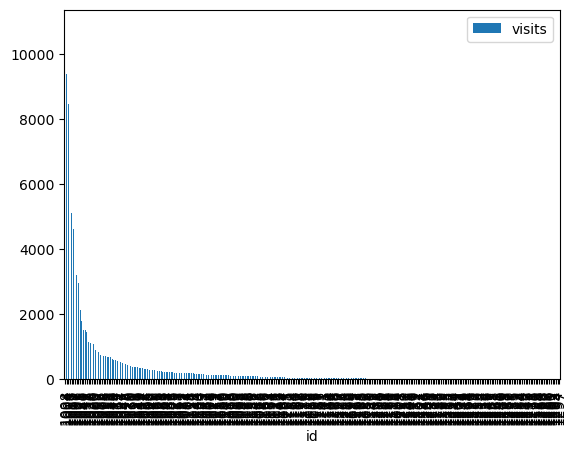

In [9]:
top_visits.drop(labels=['title','URL'],axis=1,inplace=True)
top_visits.plot.bar('id','visits')
# top_visits.plot()

<Axes: xlabel='id'>

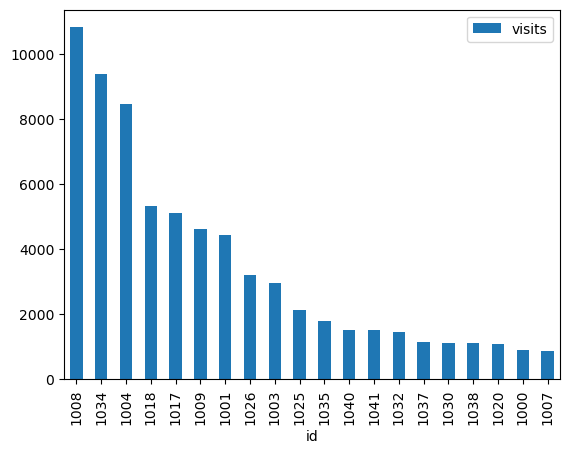

In [10]:
#查看最常用页面访问量分布
top_visits.head(20).plot.bar('id','visits')

## 3. 关联规则挖掘

**使用Apriori算法或FP-growth算法，根据用户浏览记录计算频繁项集和关联规则。**

In [11]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Apriori算法计算频繁项集
te = TransactionEncoder()
encoded_data = te.fit_transform(visit_data['vroot'])
df = pd.DataFrame(encoded_data, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.03, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.136070,(1001)
1,0.090734,(1003)
2,0.258720,(1004)
3,0.331265,(1008)
4,0.141481,(1009)
5,0.156155,(1017)
6,0.162942,(1018)
7,0.033230,(1020)
8,0.064902,(1025)
9,0.098438,(1026)


In [12]:
# 使用关联规则算法计算关联规则
association_results = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
association_results[['antecedents','consequents']]

,antecedents,consequents
0,(1001),(1003)
1,(1003),(1001)
2,(1004),(1001)
3,(1001),(1004)
4,(1001),(1017)
...,...,...
57,"(1008, 1034)",(1017)
58,"(1017, 1034)",(1008)
59,(1008),"(1017, 1034)"
60,(1017),"(1008, 1034)"


## 4. 结果评估

**计算关联规则的支持度、置信度和提升度，得出强关联规则。**

In [13]:
# 展示关联规则的支持度、置信度和提升度
rules = association_results[['antecedents','consequents','support','confidence','lift']].copy(deep = True)
rules['antecedents_names'] = rules['antecedents'].apply(lambda x: [id2name[item] for item in x if item in id2name])
rules['consequents_names'] = rules['consequents'].apply(lambda x: [id2name[item] for item in x if item in id2name])
rules

,antecedents,consequents,support,confidence,lift,antecedents_names,consequents_names
0,(1001),(1003),0.055211,0.405752,4.471879,"[""Support Desktop""]","[""Knowledge Base""]"
1,(1003),(1001),0.055211,0.608491,4.471879,"[""Knowledge Base""]","[""Support Desktop""]"
2,(1004),(1001),0.048577,0.187758,1.379862,"[""Microsoft.com Search""]","[""Support Desktop""]"
3,(1001),(1004),0.048577,0.356998,1.379862,"[""Support Desktop""]","[""Microsoft.com Search""]"
4,(1001),(1017),0.032405,0.238149,1.525075,"[""Support Desktop""]","[""Products ""]"
...,...,...,...,...,...,...,...
57,"(1008, 1034)",(1017),0.031732,0.197338,1.263731,"[""Free Downloads"", ""Internet Explorer""]","[""Products ""]"
58,"(1017, 1034)",(1008),0.031732,0.670110,2.022883,"[""Products "", ""Internet Explorer""]","[""Free Downloads""]"
59,(1008),"(1017, 1034)",0.031732,0.095792,2.022883,"[""Free Downloads""]","[""Products "", ""Internet Explorer""]"
60,(1017),"(1008, 1034)",0.031732,0.203211,1.263731,"[""Products ""]","[""Free Downloads"", ""Internet Explorer""]"


In [14]:
# 选取提升度不小于3且置信度不小于0.6的关联规则作为强关联规则
rules[(rules['lift']>=3)&(rules['confidence']>=0.6)]

,antecedents,consequents,support,confidence,lift,antecedents_names,consequents_names
1,(1003),(1001),0.055211,0.608491,4.471879,"[""Knowledge Base""]","[""Support Desktop""]"
35,(1037),(1009),0.032436,0.914655,6.464841,"[""Windows 95""]","[""Windows Family of OSs""]"
41,(1035),(1018),0.046070,0.841429,5.163977,"[""Windows95 Support""]","[""isapi""]"
45,"(1018, 1003)",(1001),0.033230,0.708605,5.207633,"[""isapi"", ""Knowledge Base""]","[""Support Desktop""]"
46,"(1001, 1003)",(1018),0.033230,0.601883,3.693843,"[""Support Desktop"", ""Knowledge Base""]","[""isapi""]"


**根据以上关联规则表可以看出强关联规则有：**    
（1）[1003]->[1001]   
（2）[1037]->[1009]  
（3）[1035]->[1018]  
（4）[1003, 1018]->[1001]  
（5）[1003, 1001]->[1018]  
**即：**  
（1）[Knowledge Base]->[Support Desktop]   
（2）[Windows 95]->[Windows Family of OSs]  
（3）[Windows95 Support]->[isapi]  
（4）[Knowledge Base, isapi]->[Support Desktop]  
（5）[Knowledge Base, Support Desktop]->[isapi]  

## 5. 结果分析与应用

**分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验。**

**网站导航结构优化建议如下：**  
（1）在Knowledge Base（1003）网站中，提供对Support Desktop（1001）、isapi（1018）等的导航  
（2）在Support Desktop（1001）网站中，提供对isapi（1018）的导航  
（3）在isapi（1018）网站中，提供对Support Desktop（1001）的导航  
（4）在Windows 95（1037）网站中，提供对Windows Family of OSs（1009）的导航  
（5）在Windows95 Support（1035）网站中，提供对isapi（1018）的导航  